Procesando frame 48/48, motion 6.15 rad

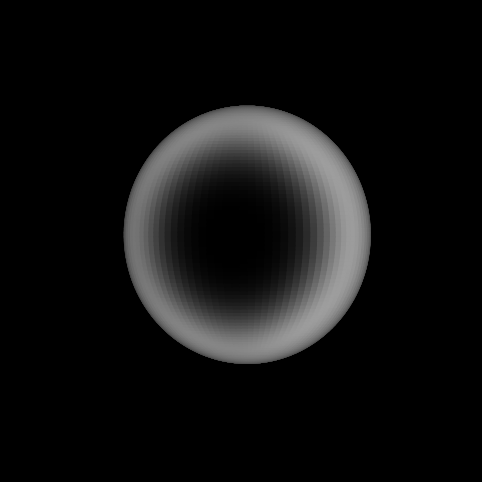

In [1]:
%matplotlib inline
#libraries
import numpy as np
import pandas as pd
import astropy.units as u
from astropy.constants import R_sun
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import animation
from sklearn.preprocessing import normalize
import astropy.units as u
import os
os.makedirs("frames", exist_ok=True)
#functions 

# convertion function 
def convertion_radians(degree):
    return np.deg2rad(degree)

#function to calculate angular velocity    
def spot_theta(rotation_period, spot_colatitude, relative_shear):
    """
    Parameters:
    - rotation_period: rotation period of the sta
    - initial_latitude: latitud of spot(radians)
    - relative_shear: parameter between pole and equator
    Returns:
    - angular velocity.
    """
    latitude = np.pi / 2 - spot_colatitude #------->the spehre latitude is from 0  to 2pi, so in equator the colatitude will be pi?2
    angular_vel_equa= 2*np.pi*u.rad/rotation_period
    angular_velocity = angular_vel_equa*(1-relative_shear*np.sin(latitude)**2)
    return angular_velocity  

#flux function
def flux_plot(flux):
    ''' Function take a list normalizing the flux, converting the list in a csv file and rename the columns
    and return a plot    
    '''
    flux_norm = normalize([flux], norm="max")[0]
    df = pd.DataFrame(flux_norm)
    df.to_csv("lc_high.csv")
    lc = pd.read_csv("lc_high.csv")
    lc = lc.rename(columns={'Unnamed: 0': 'Days', '0': 'flux_normalized'})#-----> change the name of the columns
    lc.to_csv('lc_high_name.csv')
    return lc.plot(x="Days", y="flux_normalized", alpha=0.5)#----->simple plot of lc


# limb darkening function 
def limbdarkening(u):
    '''calculate a limb darkening lineal and put it to the spehre'''
    return (1 - u * (1 - mu))

#limb darkening quadratic     
def quadratic(u):
    """
    Calculates the intensity of a given cell in the stellar surface using a
    quadratic limb-darkening law.

  """

    return (1 - u * (1 - mu) - u * (1 - mu) ** 2)


def logarithmic(u):
    """
    Calculates the intensity of a given cell in the stellar surface using a
    logarithmic limb-darkening law.

  
    """
    
    return (1 - u * (1 - mu) - u * mu * np.log(mu) ** 2)


#function that create a gaussian mask to represent spots
def spot_mask(theta_mesh, spot_theta_rad,phi_mesh,spot_phi_rad):
    '''function for creating spot mask, that could change the size and shape of the spot
    using a gaussian function
    '''
    delta_theta = np.arccos(np.cos(theta_mesh - spot_theta_rad.value))
    delta_phi = np.abs(phi_mesh - spot_phi_rad)
    distance_squared = delta_theta**2 + delta_phi**2
    sigma_squared = (spot_radius_rad / 2)**2
    return np.exp(-distance_squared**2/ (2* sigma_squared))
    #return np.where(np.abs(distance_squared) <= 0.6, 1, 0)

def spot_mask_binary(theta_mesh, spot_theta_rad, phi_mesh, spot_phi_rad, spot_radius_rad):
    """Máscara binaria: 1 dentro del radio de la mancha, 0 fuera"""
    delta_theta = np.arccos(np.cos(theta_mesh - spot_theta_rad.value))
    delta_phi = np.abs(phi_mesh - spot_phi_rad)
    distance_squared = delta_theta**2 + delta_phi**2
    return np.where(distance_squared <= spot_radius_rad**2, 1, 0)

def spot_mask_hard(theta_mesh, spot_theta_rad, phi_mesh, spot_phi_rad, radius_rad):
    delta_theta = np.arccos(np.cos(theta_mesh - spot_theta_rad.value))
    delta_phi = np.abs(phi_mesh - spot_phi_rad)
    distance_squared = delta_theta**2 + delta_phi**2
    return np.where(distance_squared <= radius_rad**2, 1.0, 0.0)



#animation Function
#@profile
def animate(i, gray_texture, mu, spot_theta_rad, spot_phi_rad, spot_radius_rad,
            theta_mesh, phi_mesh, x, y, z, ax_sphere, elev, azim, fluxes, total_frames):#ax_curve, line_curve, fluxes, total_frames):
    """ Function where is created the motion and call functions"""




    ax_sphere.clear()
    ax_sphere.set_axis_off()
    ax_sphere.view_init(elev=elev, azim=azim)
    texture = np.copy(gray_texture)

    spot_theta_motion = spot_theta_rad*u.rad + angular_velocity*i*cadence_time.to(u.day)

    spot_mask_motion = spot_mask(theta_mesh, spot_theta_motion, phi_mesh, spot_phi_rad)

    #spot_mask_motion = spot_mask_binary(theta_mesh, spot_theta_motion, phi_mesh, spot_phi_rad, spot_radius_rad)
    
    #spot_mask_motion = spot_mask_hard(theta_mesh, spot_theta_motion, phi_mesh, spot_phi_rad, spot_radius_rad)
  

    
    # Add texture to spot
    #texture = gray_texture * (1 - spot_mask_motion)
    texture *=(1-spot_mask_motion) 


    # Plot surface
    #surf = ax_sphere.plot_surface(x, y, z, rstride=1, cstride=1, facecolors=texture, shade=False)
    surf = ax_sphere.plot_surface(x, y, z, rstride=1, cstride=1, facecolors=plt.cm.gray(texture), shade=False)

    visible_mask = mu > 0  # máscara booleana de la cara visible

    # --- OPCIÓN 1: Flujo simple (suma directa de la zona visible)
    total_flux = np.sum(texture[visible_mask])
  

    #total_flux = np.sum(texture)
    fluxes.append(total_flux)
    
    #Normalized curve
    #fluxes_normalized = normalize([fluxes], norm="max")[0]
    #line_curve.set_data(np.arange(len(fluxes))*(cadence_time.to(u.day)).value, fluxes_normalized)
    #line_curve.set_data(np.arange(len(fluxes)), fluxes)

    print(f"Procesando frame {i+1}/{total_frames}, motion {spot_theta_motion:.2f}",  end='\r')  # -------> to see the process
    # 🔽 Aquí es donde guardás el PNG de cada frame
    filename = f"frames/frame_{i:03d}.png"
    plt.savefig(filename, dpi=150, bbox_inches='tight', pad_inches=0)

    

    #return[surf, line_curve]
    return[surf]

if __name__ == '__main__':
    
    # Stellar parameters 
    r = 1* u.R_sun
    res = 100#--->resolution
    constant = 0.8  # limb darkening coefficient
    rotation_period = 1* u.day #--->rotation period of the star
    
    # Point of view of the sphere
    elev = 0
    azim = 0
    
    # parameters position of the spot
    spot_theta_deg = 0 #------>Longitude
    spot_phi_deg = 90 #------>Latitude
    spot_radius_deg = 60
    
    #parameters of how many days periods
    observing_baseline_days = 1* u.day#----> Observation time
    cadence_time = 30 * u.minute#----> Cadence
    
    # frames
    total_frames = (observing_baseline_days / cadence_time).decompose().value
    total_frames = int(total_frames) 
    
    #Parameter of differential rotation
    relative_shear_coeff = 0.2
    
    #creating angles
    theta = np.linspace(0, 2*np.pi, res)
    phi = np.linspace(0, np.pi, res)
    
    #meshgrid for creation of the sphere surface
    theta_mesh, phi_mesh = np.meshgrid(theta, phi)
    
    x = r * np.sin(phi_mesh) * np.cos(theta_mesh)
    y = r * np.sin(phi_mesh) * np.sin(theta_mesh)
    z = r * np.cos(phi_mesh)
    
    # gray texture 
    gray_texture = np.ones((res, res))  # intensidad 1 = blanco


    
    #convertion paraneters
    spot_phi_rad = convertion_radians(spot_phi_deg)
    spot_radius_rad = convertion_radians(spot_radius_deg)
    spot_theta_rad = convertion_radians(spot_theta_deg)
    elev_rad = convertion_radians(elev)
    azim_rad = convertion_radians(azim)
    
    v_x = np.cos(elev_rad) * np.cos(azim_rad)
    v_y = np.cos(elev_rad) * np.sin(azim_rad)
    v_z = np.sin(elev_rad)
    
    # Limb darkening
    mu = (x * v_x + y * v_y + z * v_z) / r
    mu = np.clip(mu, 0, 1)
    
    lineal_darkening = limbdarkening(constant)
    gray_texture *= lineal_darkening

    # quadratic_darkening = quadratic(constant)
    # gray_texture *= quadratic_darkening

    # log_limb = logarithmic(constant)
    # gray_texture *= log_limb

    
    #motion of spot
    angular_velocity = spot_theta(rotation_period, spot_phi_rad, relative_shear_coeff)#----->only calculate once
    
    
        #Creating list for fluxes
    fluxes = []
    # Figure
    plt.style.use('dark_background')# -----> dark background
    fig = plt.figure(figsize=(12, 6))
    ax_sphere = fig.add_subplot(projection='3d') 
    #ax_sphere = fig.add_subplot(121, projection='3d')
    #ax_curve = fig.add_subplot(122)
    ax_sphere.set_box_aspect((0.98, 1, 0.95))#-------> symtries of the sun 
 
    ax_sphere.set_axis_off()
    
    #ax_curve.set_title('Lightcurve', color='white')
    #ax_curve.set_xlabel('Days')
    #ax_curve.set_ylabel('Normalized flux')
    #ax_curve.set_xlim(0, total_frames*(cadence_time.to(u.day)).value)
    #ax_curve.set_ylim(3200,3500)
    #ax_curve.set_facecolor('black')
    #line_curve, = ax_curve.plot([], [], color='orange')
    
    for i in range(total_frames):
        animate(i, gray_texture, mu, spot_theta_rad, spot_phi_rad, spot_radius_rad,
            theta_mesh, phi_mesh, x, y, z, ax_sphere, elev, azim, fluxes, total_frames)
        plt.savefig(f"frames/frame_{i:03d}.png", dpi=150)
        #ax_sphere.clear()
        #plt.close()

    #for i in range(total_frames):
     #   ani = animation.FuncAnimation(fig, animate, frames=total_frames, interval=60, blit=False, repeat=False,
      #      fargs=(gray_texture, mu, spot_theta_rad, spot_phi_rad, spot_radius_rad,
                   #theta_mesh, phi_mesh, x, y, z, ax_sphere, elev, azim, fluxes, total_frames)#ax_curve,
                   #line_curve, fluxes, total_frames)
       # )
        
        #ani.save('mask.gif', writer='ffmpeg', fps=20)
        #plt.show()



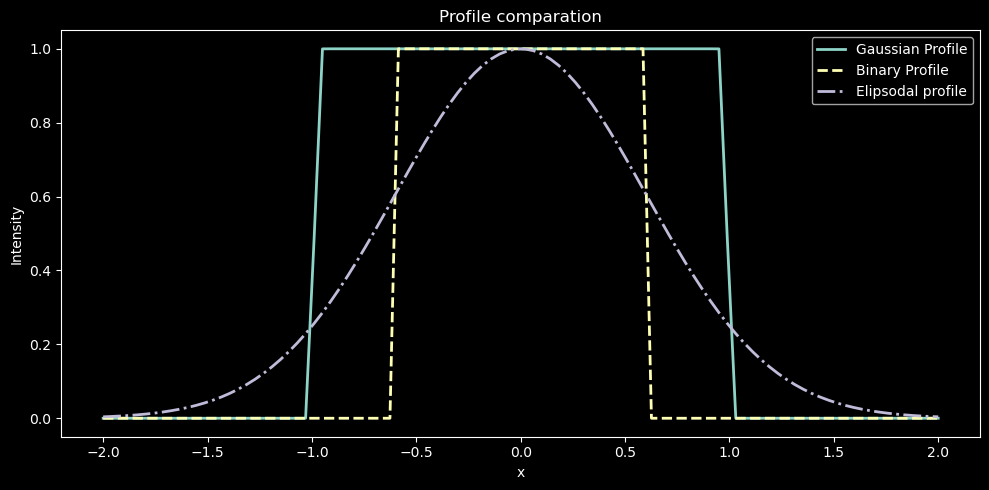

In [10]:
import numpy as np
import matplotlib.pyplot as plt


r = np.linspace(-2, 2, 100)  # puede representar distancia angular en radianes

# Parameters
sigma_gauss = 0.3
radius_binary = 0.6
sigma_ellip = 0.6

# Profiles
gaussian_profile = np.exp(-r**200 / (2 * sigma_gauss**2))
binary_profile = np.where(np.abs(r) <= radius_binary, 1, 0)

elliptical_profile = np.exp(-r**2 / (2 * sigma_ellip**2))

# plots
plt.figure(figsize=(10, 5))
plt.plot(r, gaussian_profile, label='Gaussian Profile', linewidth=2)
plt.plot(r, binary_profile, label='Binary Profile', linestyle='--', linewidth=2)
plt.plot(r, elliptical_profile, label='Elipsodal profile', linestyle='-.', linewidth=2)

plt.xlabel('x')
plt.ylabel('Intensity')
plt.title('Profile comparison')
plt.legend()
plt.tight_layout()
plt.show()


### Taking the images and making a mean of intensity

In [3]:
from PIL import Image
import numpy as np
import glob

# getting the frames
frame_files = sorted(glob.glob("frames/frame_*.png"))

# creating a list of the new fluxes
fluxes_com = []

for filename in frame_files:
    # convert images in gray scale
    img = Image.open(filename).convert('L')  # 'L' = 8-bit pixels, black and white
    img_array = np.array(img, dtype=np.float64)

    # Calculate intensities
    flux_total = np.sum(img_array)
    fluxes_com.append(flux_total)



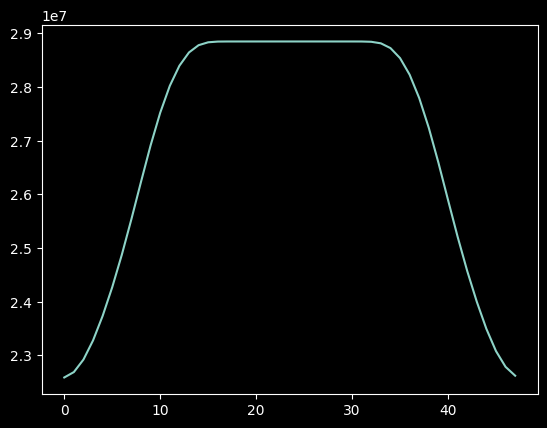

In [6]:
plt.plot(fluxes_com)

### we are going to normalized the two list of fluxes in order to compare the plots

In [4]:
fluxes_normalized_simluated = normalize([fluxes], norm="max")[0]
fluxes_normalized_png = normalize([fluxes_com], norm="max")[0]


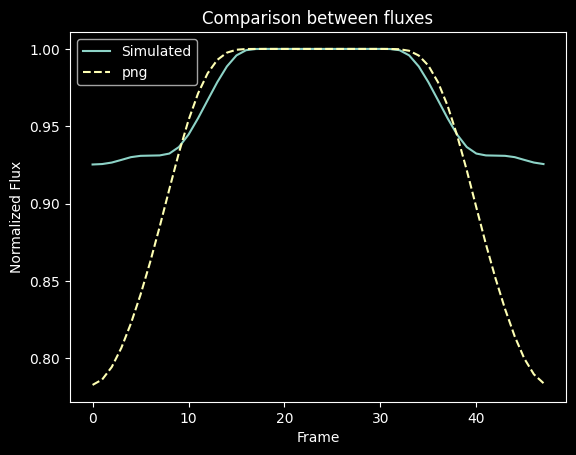

In [14]:
plt.plot(fluxes_normalized_simluated, label='Simulated')
plt.plot(fluxes_normalized_png, label='png', linestyle='--')
plt.xlabel("Frame")
plt.ylabel("Normalized Flux")
plt.legend()
plt.title("Comparison between fluxes")
plt.show()

### now with thw limb darkening effect

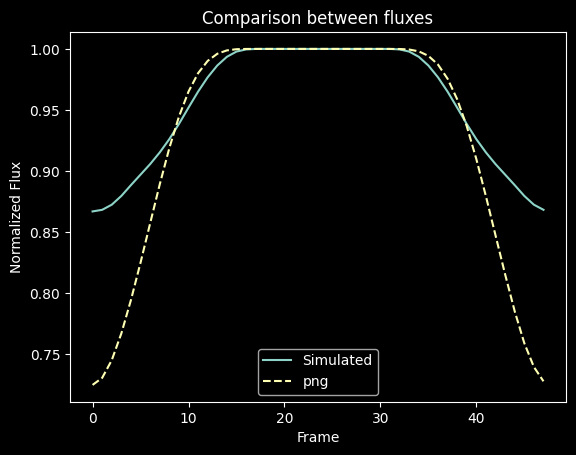

In [19]:
plt.plot(fluxes_normalized_simluated, label='Simulated')
plt.plot(fluxes_normalized_png, label='png', linestyle='--')
plt.xlabel("Frame")
plt.ylabel("Normalized Flux")
plt.legend()
plt.title("Comparison between fluxes")
plt.show()

### check the limb darkening effect

In [89]:
frame_limb_darkening = sorted(glob.glob("frames/frame_025.png"))[0]  #
img_limb = Image.open(frame_limb_darkening).convert("L")
img_limb_array = np.array(img_limb, dtype=np.float64)

In [90]:
np.shape(img_limb_array)

(900, 1800)

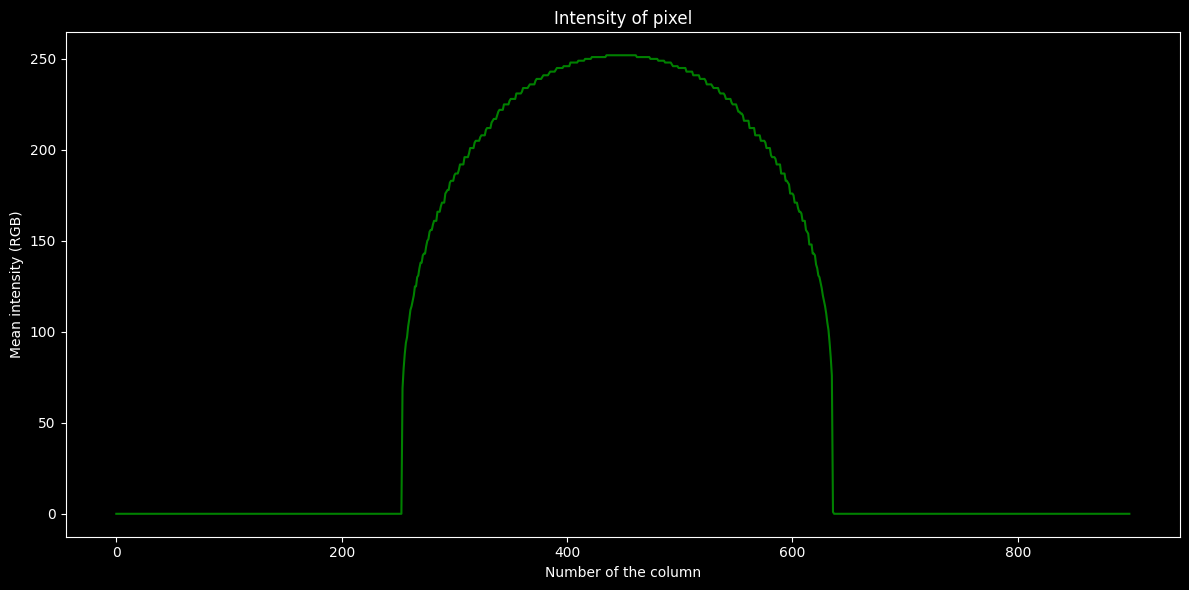

In [57]:

half = img_limb_array[:,900]#------>take the have of the image to see the value of pixel with limb darkening


x = np.arange(half.shape[0])#-------->number of columns


plt.figure(figsize=(12, 6))
plt.plot(x, half, color='g')
plt.title('Intensity of pixel')
plt.xlabel('Number of the column')
plt.ylabel('Mean intensity (RGB)')
plt.tight_layout()
plt.show()


### making test with quadratic limb darkening

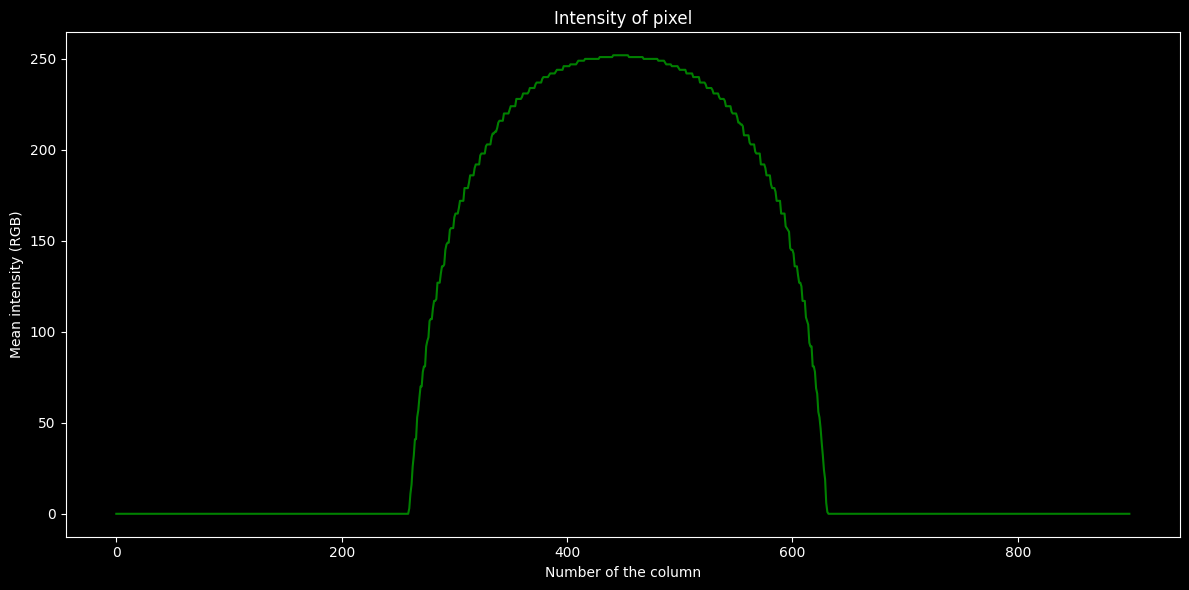

In [81]:

half = img_limb_array[:,900]#------>take the have of the image to see the value of pixel with limb darkening


x = np.arange(half.shape[0])#-------->number of columns


plt.figure(figsize=(12, 6))
plt.plot(x, half, color='g')
plt.title('Intensity of pixel')
plt.xlabel('Number of the column')
plt.ylabel('Mean intensity (RGB)')
plt.tight_layout()
plt.show()


### making test with logarithmic limb darkening

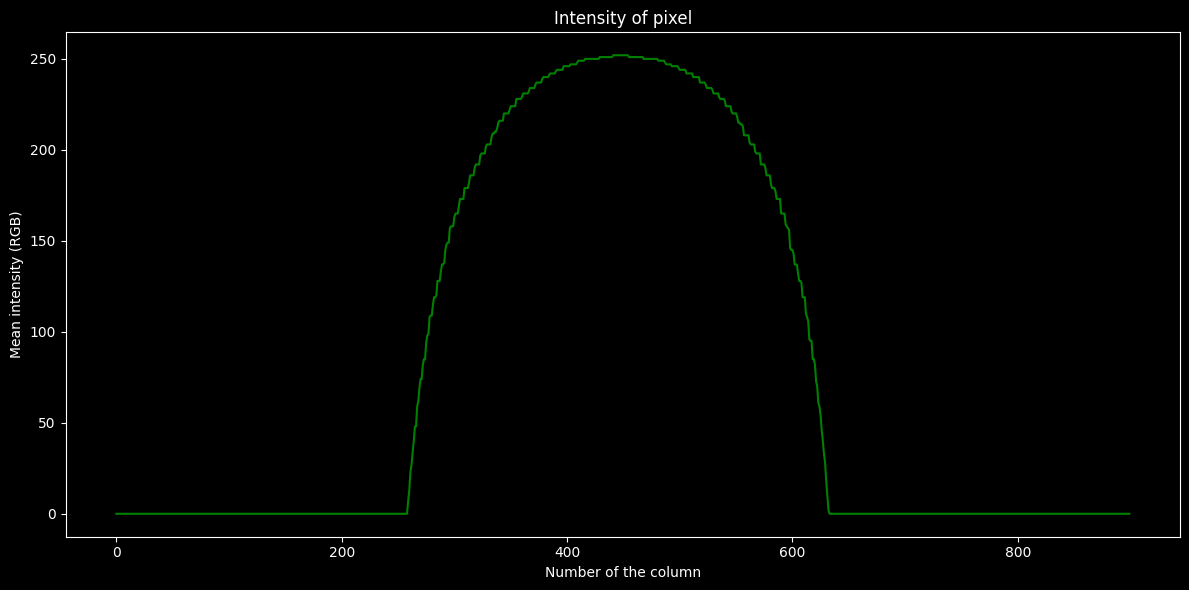

In [91]:
half = img_limb_array[:,900]#------>take the have of the image to see the value of pixel with limb darkening


x = np.arange(half.shape[0])#-------->number of columns


plt.figure(figsize=(12, 6))
plt.plot(x, half, color='g')
plt.title('Intensity of pixel')
plt.xlabel('Number of the column')
plt.ylabel('Mean intensity (RGB)')
plt.tight_layout()
plt.show()


### looking this images is almost the same
but if we compare the images we are going to see a difference